In [183]:
import pandas as pd
import numpy as np
import matplotlib as pl
import seaborn as sns; sns.set(color_codes=True)
import sqlite3
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext sql
%sql sqlite:///database.sqlite

u'Connected: None@database.sqlite'

In [3]:
try:    
    db = sqlite3.connect('database.sqlite')
    c = db.cursor()
    print "Successfully connected to the database"
except IntegrityError:
    print"Did not successfully connect to database"

Successfully connected to the database


In [7]:
# Primary results
df_primary_results.head()

,state,state_abbreviation,county,fips,party,candidate,votes,fraction_votes,county_state
0,Alabama,AL,Autauga,1001,Republican,Donald_Trump,5387,0.445,Autauga_AL
1,Alabama,AL,Autauga,1001,Republican,Ted_Cruz,2482,0.205,Autauga_AL
2,Alabama,AL,Autauga,1001,Republican,Marco_Rubio,1785,0.148,Autauga_AL
3,Alabama,AL,Autauga,1001,Republican,Ben_Carson,1764,0.146,Autauga_AL
4,Alabama,AL,Autauga,1001,Republican,John_Kasich,421,0.035,Autauga_AL


In [8]:
# County Facts data
df_county_facts.head()

,fips,area_name,state_abbreviation,PST045214,PST040210,PST120214,POP010210,AGE135214,AGE295214,AGE775214,...,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210,county_state
0,1001,Autauga,AL,55395,54571,1.5,54571,6.0,25.2,13.8,...,31.7,0,0,598175,12003,88157,131,594.44,91.8,Autauga_AL
1,1003,Baldwin,AL,200111,182265,9.8,182265,5.6,22.2,18.7,...,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6,Baldwin_AL
2,1005,Barbour,AL,26887,27457,-2.1,27457,5.7,21.2,16.5,...,27.0,0,0,188337,6334,0,8,884.88,31.0,Barbour_AL
3,1007,Bibb,AL,22506,22919,-1.8,22915,5.3,21.0,14.8,...,0.0,0,0,124707,5804,10757,19,622.58,36.8,Bibb_AL
4,1009,Blount,AL,57719,57322,0.7,57322,6.1,23.6,17.0,...,23.2,341544,0,319700,5622,20941,3,644.78,88.9,Blount_AL


# Vote Summary:

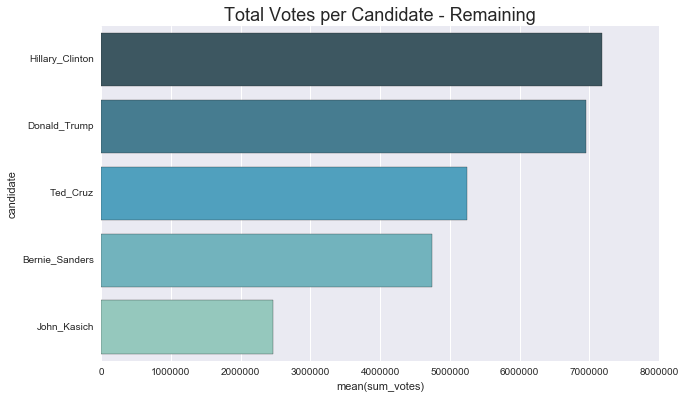

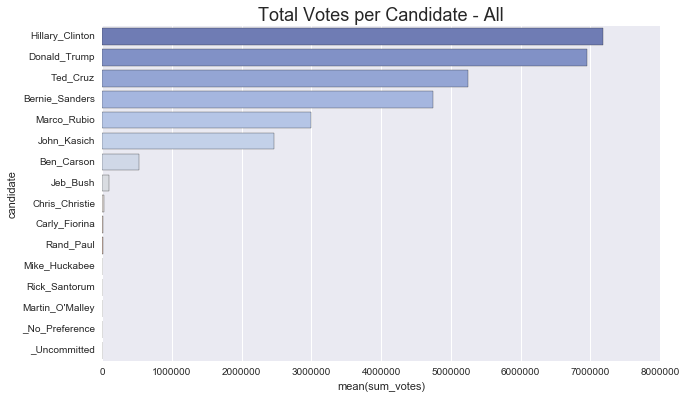

In [246]:
votes_sum = pd.read_sql_query('SELECT candidate, party, sum(votes) as sum_votes FROM primary_results GROUP BY candidate, party ORDER BY sum_votes desc, party;',db)
to_del = votes_sum.loc[votes_sum['candidate'].isin(['Jeb_Bush', 'Ben_Carson','Rand_Paul','Chris_Christie','Carly_Fiorina','Rick_Santorum','Mike_Huckabee',"Martin_O'Malley","Marco_Rubio","_No_Preference","_Uncommitted"])].index.tolist()
votes = votes_sum.drop(to_del)

sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes, palette="GnBu_d", saturation=.8)
sns.plt.title('Total Votes per Candidate - Remaining', fontsize = 18)

sns.plt.figure(figsize=(10,6))
sns.barplot(y = 'candidate', x = 'sum_votes', data = votes_sum, palette="coolwarm", saturation=.5)
sns.plt.title('Total Votes per Candidate - All', fontsize = 18)

In [4]:
#Primary Results:
#%sql SELECT * FROM primary_results
%sql ALTER TABLE primary_results ADD COLUMN county_state TEXT;
%sql UPDATE primary_results SET county_state = (county || "_" || state_abbreviation);
%sql UPDATE primary_results SET candidate = Replace(candidate,' ','_');

#Republican Table:
%sql CREATE TABLE Republicans AS SELECT * FROM primary_results;
%sql DELETE FROM Republicans WHERE(party ='Democrat') 

#Democrat Table:
%sql CREATE TABLE Democrats AS SELECT * FROM primary_results;
%sql DELETE FROM Democrats WHERE(party ='Republican') 

#County Facts:
%sql UPDATE county_facts SET state_abbreviation = NULL WHERE state_abbreviation = '';
%sql DELETE FROM county_facts WHERE state_abbreviation IS NULL;
%sql ALTER TABLE county_facts ADD COLUMN county_state TEXT;
%sql UPDATE county_facts SET area_name = SUBSTR(area_name,1, LENGTH(area_name)-7);
%sql UPDATE county_facts SET county_state = (area_name || "_" || state_abbreviation);
%sql UPDATE county_facts SET county_state = REPLACE(county_state,'"','');

#Output County_Facts_Description as CSV file (.mode csv)
#%sql .output county_facts_dict.csv # command in terminal

Done.
13212 rows affected.
13212 rows affected.
Done.
4060 rows affected.
Done.
9152 rows affected.
52 rows affected.
52 rows affected.
Done.
3143 rows affected.
3143 rows affected.
3143 rows affected.


[]

In [5]:
# Generate Dataframe
df_primary_results = pd.read_sql_query('SELECT * FROM primary_results', db) #Primary Results 
df_county_facts = pd.read_sql_query('SELECT * FROM county_facts',db) #County Facts
df_republicans = pd.read_sql_query('SELECT * FROM Republicans',db) # Republican Table
df_democrats = pd.read_sql_query('SELECT * FROM Democrats', db) # Democrat Table

#County Facts Dictionary:
df_county_facts_dictionary = pd.read_sql_query('SELECT * FROM county_facts_dictionary ',db)

In [6]:
#shape of tables:
prim = df_primary_results.shape[0]
rep = df_republicans.shape[0]
dem = df_democrats.shape[0]
print "Primary Results..."
print "Total Number of Elements = {}; Republican: {}, Democrat :{}".format(prim,rep,dem)
print "Number of Features =", df_primary_results.shape[1]

#County Facts (shape):
print "\nCounty Facts..."
print "Total Number of Elements =", df_county_facts.shape[0]
print "Number of Features =", df_county_facts.shape[1] -4


Primary Results...
Total Number of Elements = 13212; Republican: 9152, Democrat :4060
Number of Features = 9

County Facts...
Total Number of Elements = 3143
Number of Features = 51


In [9]:
#Identify the Republican winner in each county:
#%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Republicans GROUP BY county ORDER BY state;
%sql CREATE TABLE Republican_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import republican_winners.csv Republican_Winner

#Identify the Democrat winner in each county:
#%sql SELECT state, state_abbreviation, county, fips, party, candidate, MAX(votes), fraction_votes, county_state FROM Democrats GROUP BY county ORDER BY state;
%sql CREATE TABLE Democrat_Winner(state TEXT NOT NULL, state_abbreviation TEXT NOT NULL, county TEXT NOT NULL, fips INTEGER NOT NULL, party TEXT NOT NULL, candidate TEXT NOT NULL, votes INTEGER NOT NULL, fraction_votes INTEGER NOT NULL, county_state TEXT NOT NULL);
#.import democrat_winners.csv Democrat_Winner 

Done.
Done.


[]

In [ ]:
# Join Tables:
%sql SELECT * FROM Republican_Winner INNER JOIN county_facts WHERE Republican_Winner.county_state = county_facts.county_state;
%sql SELECT * FROM Democrat_Winner INNER JOIN county_facts WHERE Democrat_Winner.county_state = county_facts.county_state;

In [30]:
#Dataframe for Republican winners per county w/ county facts:
republican_data = pd.read_csv("republican_winners_county_facts.csv")
republican_data.drop(republican_data.columns[[1,9,10,11,63]], axis=1, inplace=True) #Drop repeated rows

#Dataframe for Democrat winners per county w/ county facts:
democrat_data = pd.read_csv("democrat_winners_county_facts.csv") 
democrat_data.drop(democrat_data.columns[[1,9,10,11,63]], axis=1, inplace=True) #Drop repeated rows

republican_data.head()

,state,county,fips,party,candidate,votes,fraction_votes,county_state,PST045214,PST040210,...,SBO415207,SBO015207,MAN450207,WTN220207,RTN130207,RTN131207,AFN120207,BPS030214,LND110210,POP060210
0,Alabama,Autauga,1001,Republican,Donald_Trump,5387,0.445,Autauga_AL,55395,54571,...,0.7,31.7,0,0,598175,12003,88157,131,594.44,91.8
1,Alabama,Baldwin,1003,Republican,Donald_Trump,23618,0.469,Baldwin_AL,200111,182265,...,1.3,27.3,1410273,0,2966489,17166,436955,1384,1589.78,114.6
2,Alabama,Barbour,1005,Republican,Donald_Trump,1710,0.501,Barbour_AL,26887,27457,...,0.0,27.0,0,0,188337,6334,0,8,884.88,31.0
3,Alabama,Bullock,1011,Republican,Donald_Trump,313,0.565,Bullock_AL,10764,10915,...,0.0,38.8,0,0,43810,3995,3670,1,622.81,17.5
4,Alabama,Calhoun,1015,Republican,Donald_Trump,8960,0.451,Calhoun_AL,115916,118586,...,0.5,24.7,2679991,0,1542981,13678,186533,114,605.87,195.7


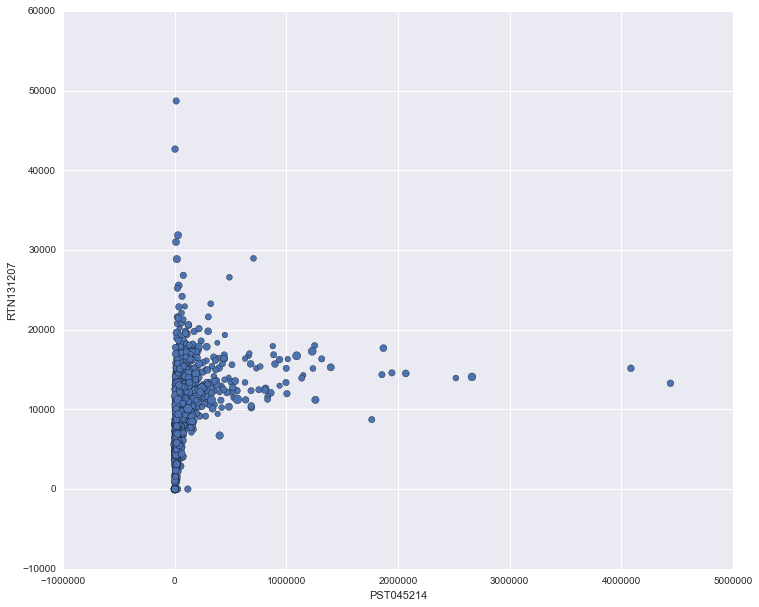

In [129]:
#Features:
rep_features_cols = list(republican_data.columns[8:])
rep_features = republican_data[rep_features_cols]
#Target: candidate winner
rep_target_col = republican_data.columns[4]
rep_target = republican_data[rep_target_col] 

#print rep_features.head()
#print rep_target.head()

republican_data.plot.scatter(x='PST045214', y='RTN131207', figsize=(12,10), s=republican_data['fraction_votes']*100)